In [1]:
import pymysql.cursors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# 센서 데이터가 저장된 DB 연결

conn = pymysql.connect(
host = '220.68.27.145',
user = 'dahee',
password = 'dlekgml123',
db = 'park',
charset = 'utf8')

curs = conn.cursor(pymysql.cursors.DictCursor)

In [3]:
# 주차구역 리스트
sql = "select distinct park_id from park_info"
curs.execute(sql)
park_id = curs.fetchall()
park_id = [p_id['park_id'] for p_id in park_id]

# 요일 리스트
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# 시(hour) 리스트
hours = range(12, 18)

# 분(minute) 리스트(10분 단위로)
minutes = range(0, 60, 10)

In [4]:
# 학습 데이터 저장 경로
fw_feature = open('feature.txt', 'w', encoding='utf8')
fw_label = open('label.txt', 'w', encoding='utf8')
train_set = list()

# 주차구역별로
for p_idx, park in enumerate(park_id):
    for day_idx, day in enumerate(days):
        # 요일별로 DB에서 데이터 불러오기
        sql = "select * from park_info where park_id=%s and day=%s;"
        values = (park, day)
        curs.execute(sql, values)
        result = curs.fetchall()

        # 데이터가 없으면 넘어감
        if len(result) == 0: continue

        # DB에서 불러온 데이터를 DataFrame으로 변환
        df = pd.DataFrame(result)

        # time의 데이터 타입을 문자열로 바꾸고 hour와 minute 구함
        df = df.astype({'time':'str'})
        df['hour'] = df['time'].str[7:9]
        df['minute'] = df['time'].str[10:12]

        # 해당 시, 분 데이터 중에서 주차된 개수 계산 = count
        df = df.astype({'hour':'int', 'minute':'int'})
        for h in hours:
            feature = df[df['hour'] == h]
            for m in minutes:
                count = feature[(feature['minute'] >= m) & (feature['minute'] < m+10)]
                count = count[count['is_parking']==0]
                count = count.drop_duplicates(['node_id'])
                
                fw_feature.write(str(p_idx+1) + ',' + str(day_idx+1) + ',' + str(round(h+(m/60), 5)) + '\n')
                fw_label.write(str(len(count)) + '\n')
                
                train_set.append([str(p_idx+1), str(day_idx+1), str(round(h+(m/60), 5)), str(len(count))])
                
fw_feature.close()
fw_label.close()

dataset = pd.DataFrame(train_set, columns=['park_id', 'day', 'time', 'count'])
dataset.to_csv('park_set.csv', encoding="utf8", index=False)

conn.close()

In [5]:
# 학습 데이터와 평가 데이터 분리

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_dataset = train_dataset.astype({'park_id':'int', 'day':'int', 'time':'float', 'count':'int'})
test_dataset = test_dataset.astype({'park_id':'int', 'day':'int', 'time':'float', 'count':'int'})

In [6]:
# feature와 label 분리

train_labels = train_dataset.pop('count')
test_labels = test_dataset.pop('count')

In [7]:
# 모델 생성

def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(16, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________



....................................................................................................
................................

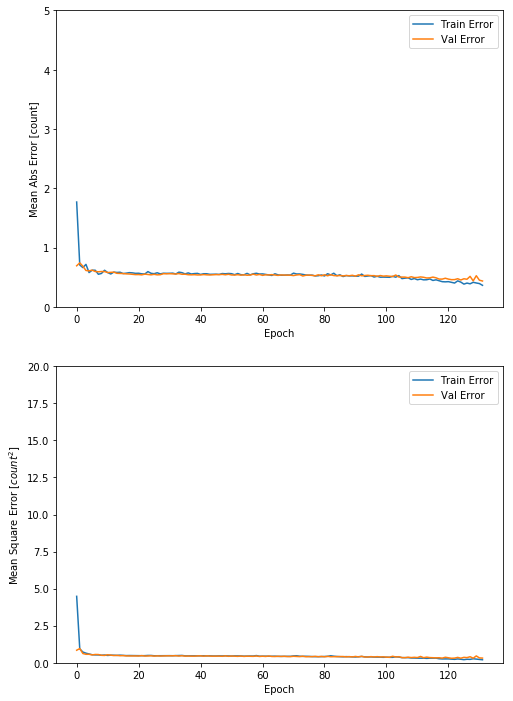

In [8]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# 에폭마다의 손실값을 그래프로 출력
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [count]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$count^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [18]:
# 예측
test_predictions = model.predict(test_dataset).flatten()

test_labels2 = test_labels.tolist()
test_predictions2 = np.round(test_predictions).astype('int').tolist()
print(test_predictions2)
print(test_labels2)

# 정확도 계산
c = 0
for i in range(len(test_labels2)):
    if test_labels2[i] == test_predictions2[i]: c += 1
        
print('Accuracy:', c/len(test_labels2))

[2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Accuracy: 0.75


In [19]:
# SavedModel로 전체 모델을 저장합니다
!mkdir -p saved_model
model.save('saved_model/my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets
